In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import neurkal
import neurkal.utils as utils

import cProfile
import pstats

import ipympl
import itertools
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
import numpy as np
from scipy.misc import derivative
from scipy.stats import norm
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
%matplotlib inline

# make Numpy raise warnings as exceptions (or not)
np.seterr(all='warn')
#np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
## Plot style setup
#rc('mathtext', default='regular')
#rcParams.update({'figure.autolayout': True})
sns.set_style("ticks", {'font_scale': 1.5})
set_palette = lambda: itertools.cycle(sns.color_palette('deep'))
#set_palette = lambda: itertools.cycle(sns.color_palette("cubehelix", 8))
#set_palette = lambda: itertools.cycle(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True))
#sns.set(font_scale=1.5)

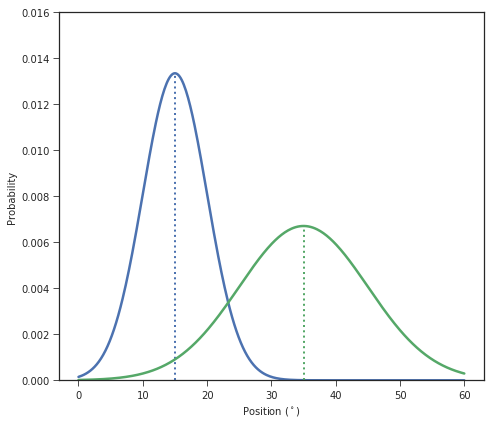

In [5]:
x = np.linspace(0, 60, 360)

mu1 = 15
sd1 = 5
mu2 = 35
sd2 = 10

pdf1 = norm.pdf(x, mu1, sd1)
pdf1 /= np.trapz(pdf1)
pdf2 = norm.pdf(x, mu2, sd2)
pdf2 /= np.trapz(pdf2)

post = pdf1 * pdf2
post /= np.trapz(post)
mu3 = x[np.argmax(post)]

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
pp = PdfPages('k0a.pdf')
ax1.set_xlabel("Position ($^\circ$)")
ax1.set_ylabel("Probability")
#ax1.set_ylim([0, max(np.max(pdf1), np.max(pdf2), np.max(post)) * 1.1])
ax1.set_ylim([0, 0.016])
c1 = next(palette)
ax1.plot([mu1, mu1], [0, np.max(pdf1)], ':', color=c1, lw=2)
ax1.plot(x, pdf1, color=c1, lw=2.5)
c2 = next(palette)
ax1.plot([mu2, mu2], [0, np.max(pdf2)], ':', color=c2, lw=2)
ax1.plot(x, pdf2, color=c2, lw=2.5)
c3 = next(palette)
#ax1.plot([mu3, mu3], [0, np.max(post)], ':', color=c3, lw=2)
#ax1.plot(x, post, color=c3, lw=2.5)


#ps = [p1, p4, p2, p3]
#labels = [p.get_label() for p in ps]
#fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

In [6]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.006]]   # constant "motor" dynamics
Z = [[0.00005]]  # motor noise variance
c = np.array([[1]])

In [7]:
# simulation parameters
p = 20  # units in input networks
th_r = [-180, 180]
d_th = [1, 1.5]
steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
#steps = 50
t_f = 100
ts = np.linspace(0, t_f, steps)

In [8]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

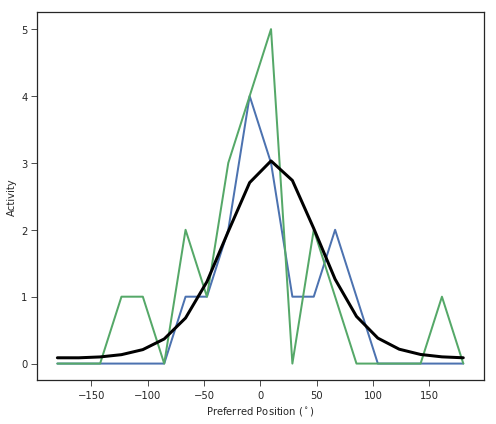

In [9]:
## Sensory input layer example activation
x = 10

sensory_code = neurkal.PopCode(n=p, space=th_r, act_func=input_act, dist=np.random.poisson)

fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xlabel("Preferred Position ($^\circ$)")
ax.set_ylabel("Activity")
pp = PdfPages('pc1.pdf')
palette = set_palette()

for _ in range(2):
    c_ = next(palette)
    ax.plot(sensory_code.prefs, sensory_code(x), '-', color=c_, lw=2)

ax.plot(sensory_code.prefs, sensory_code.mean_activity, 'k', lw=3)
fig.tight_layout()
plt.show()
pp.savefig(fig)
pp.close()

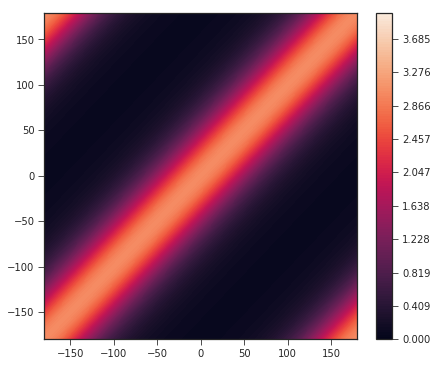

In [10]:
## Visualize activation function for sensory input layer
act = np.vectorize(input_act)
x = np.arange(*th_r, 1)
z = act(*np.meshgrid(x, x))
levels = np.linspace(np.floor(np.min(z)), np.ceil(np.max(z)), 128)

fig, ax = plt.subplots(figsize=(7, 6))
act_cf = ax.contourf(x, x, z, levels=levels)
plt.colorbar(act_cf)
plt.show()

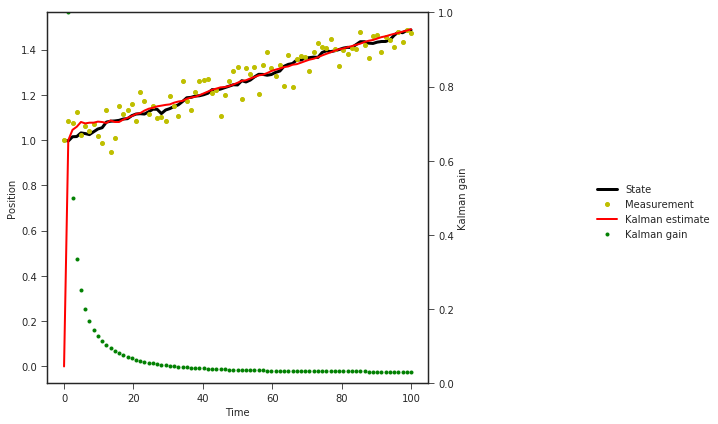

In [11]:
## test conventional kalman filter
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
q = 0.05

states = []
estimates = []
gains = []
meas = []

for t in ts:
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, q)
    meas.append(x_s[0, 0])
    kalman.step(c, x_s, Q=[[q]])
    state.update(c)
    

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('k1.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts[1:], gains[1:], '.', color='g', label="Kalman gain", ms=6)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

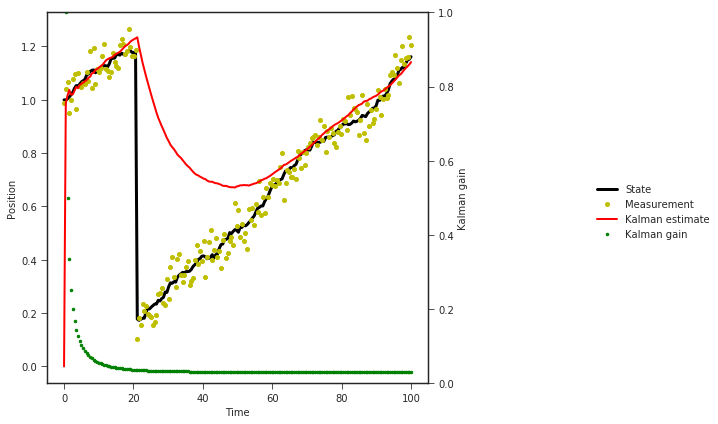

In [12]:
## test conventional kalman filter: change detection
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
q = 0.05

states = []
estimates = []
gains = []
meas = []

ts = np.linspace(0, t_f, 200)
for i, t in enumerate(ts):
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, q)
    meas.append(x_s[0, 0])
    kalman.step(c, x_s, Q=[[q]])
    if i == int(0.5 * steps):
        state.change(state.x - 1)
    state.update(c)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('k2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts[1:], gains[1:], '.', color='g', label="Kalman gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

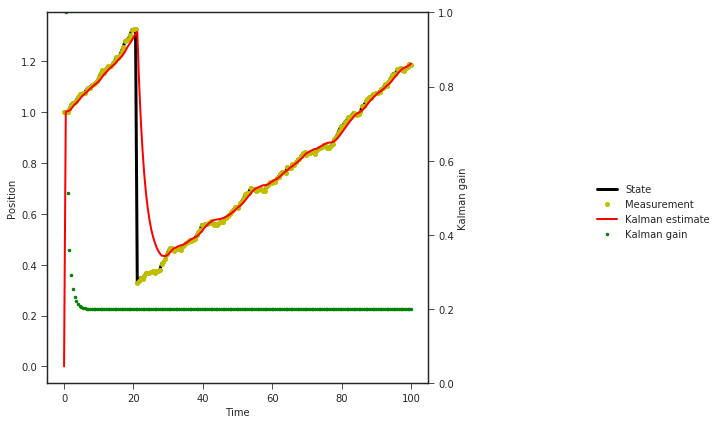

In [28]:
## test conventional kalman filter: change detection (higher sensory noise)
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
q = 0.001

states = []
estimates = []
gains = []
meas = []

for i, t in enumerate(ts):
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, q)
    meas.append(x_s[0, 0])
    kalman.step(c, x_s, Q=[[q]])
    if i == int(0.5 * steps):
        state.change(state.x - 1)
    state.update(c)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('k3.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts[1:], gains[1:], '.', color='g', label="Kalman gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

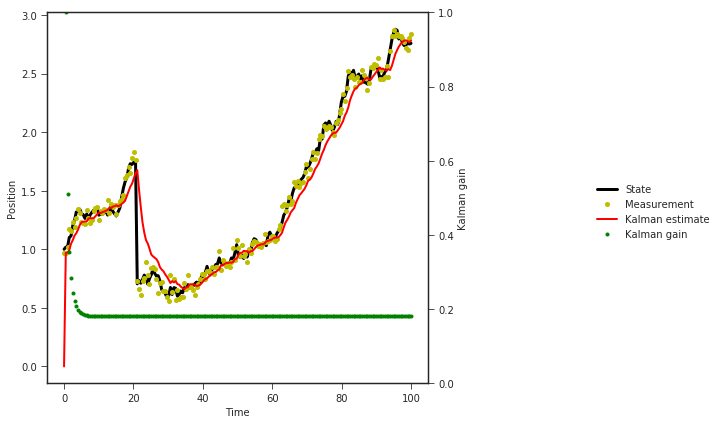

In [29]:
## test conventional kalman filter: change detection (lower motor noise)
Z = [[0.002]]
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
q = 0.05

states = []
estimates = []
gains = []
meas = []

for i, t in enumerate(ts):
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, q)
    meas.append(x_s[0, 0])
    kalman.step(c, x_s, Q=[[q]])
    if i == int(0.5 * steps):
        state.change(state.x - 1)
    state.update(c)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('k4.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts[1:], gains[1:], '.' , color='g', label="Kalman gain", ms=6)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

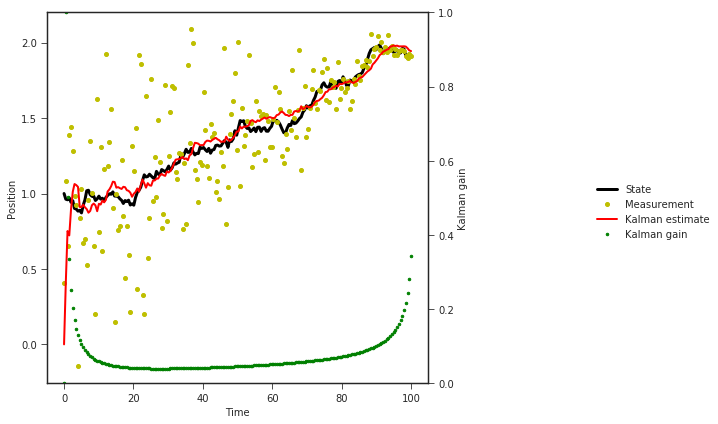

In [69]:
## test conventional kalman filter: sensory noise change mid-run
Z = [[0.0005]]
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
q0 = 0.5
q = q0
qstep = 0.5 / len(ts)

states = []
estimates = []
gains = []
meas = []

for i, t in enumerate(ts):
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, q)
    meas.append(x_s[0, 0])
    kalman.step(c, x_s, Q=[[q]])
    state.update(c)
    q -= qstep

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('k5.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, '.', color='g', label="Kalman gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

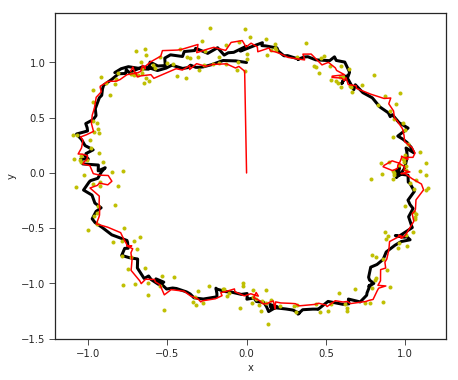

In [72]:
## test conventional kalman filter: 2D
a = 3  # angular velocity
dt = 0.01
t_f = 2.2
ts = np.arange(0, t_f, dt)
M = [[1, -a * dt],
     [a * dt, 1]]
B = [[1],
     [1]]
z_ = 0.001
Z = [[z_, 0],
     [0, z_]]
s0 = [0, 1]
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=[[0], [1]])
# sensory noise
q_ = 0.005
q = [[q_, 0],
     [0, q_]]

c = [[0]]

states = []
meas = []
estimates = []
gains = []
estimates.append(kalman.estimate)
for i, t in enumerate(ts):
    
    gains.append(kalman.gain[0, 0])
    states.append(state.x)
    x_s = state.x + utils.colvec(np.random.multivariate_normal([0, 0], q))
    meas.append(x_s)    
    kalman.step(c, x_s, Q=q)
    estimates.append(kalman.estimate)
    #if i == int(0.5 * steps):
    #    state.change(state.x - 1)
    state.update(c)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.plot(*np.hstack(states), 'k-', lw=3)
ax1.plot(*np.hstack(meas), 'y.')
ax1.plot(*np.hstack(estimates), 'r-')
plt.show()

In [5]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.03]]   # constant "motor" dynamics
Z = [[0.03]]  # motor noise variance
c = np.array([[1]])

In [6]:
# simulation parameters
p = 30  # units in input networks
th_r = [-180, 180]
d_th = [20, 30]
#steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 1000
t_f = 100
ts = np.linspace(0, t_f, steps)

In [7]:
K_w = 3
mu = 0.001
eta = 0.01

In [8]:
@jit(nopython=True)
def input_act(x, x_i):
    return 7 * (np.exp(20 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

In [18]:
sensory_input = neurkal.PopCode(n=p, space=th_r, act_func=input_act, dist=np.random.poisson)

In [37]:
sensory_input(0)
sensory_input.cr_bound

10.008003481308764

In [19]:
# visualize network weights
# TODO: why is initial estimate smooth?
# TODO: plot sensory estimates in plots below
# TODO: Why is sensory gain changing so much?
B_test = [[[0]], [[90]], [[180]]]
K_w_test = 3
weight_test_network_1 = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], sigma=[1],
                                                   motor_inputs=[], M=M, B=-np.array(B_test[0]), Z=Z,
                                                   mu=mu, eta=eta, K_w=K_w_test)
weight_test_network_2 = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], sigma=[1],
                                                   motor_inputs=[], M=M, B=-np.array(B_test[1]), Z=Z,
                                                   mu=mu, eta=eta, K_w=K_w_test)
weight_test_network_3 = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], sigma=[1],
                                                   motor_inputs=[], M=M, B=-np.array(B_test[2]), Z=Z,
                                                   mu=mu, eta=eta, K_w=K_w_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=[12, 6])
pp = PdfPages('weights.pdf')
w_hm1 = ax1.imshow(weight_test_network_1.weights)
w_hm2 = ax2.imshow(weight_test_network_2.weights)
w_hm3 = ax3.imshow(weight_test_network_3.weights)
ax1.set_title("a = 0")
ax2.set_title("a = 90")
ax3.set_title("a = 180")
ax.set_ylabel("")
#fig.colorbar(w_hm, shrink=0.5)
fig.tight_layout()
plt.show()
pp.savefig(fig)
pp.close()

<IPython.core.display.Javascript object>

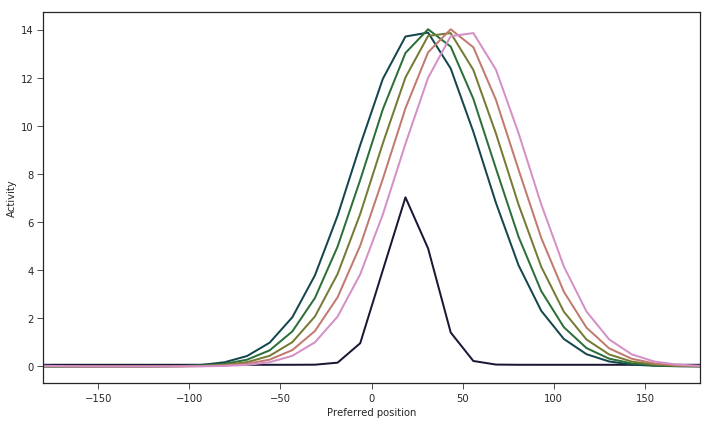

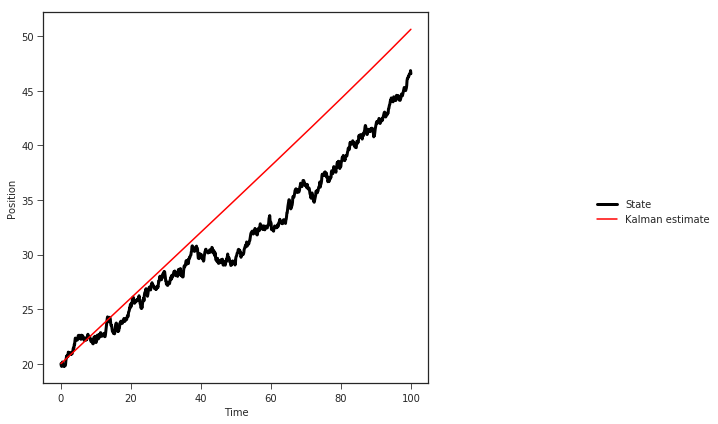

In [41]:
## Kalman network test -- only initial feedback
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

inputs = []
activities = []
states = []
estimates = []
gains = []

sensory_input(state.x[0], certain=True)

for i, t in enumerate(ts):
    inputs.append(np.copy(sensory_input.activity))
    states.append(state.x[0])
    gains.append(kalman_network.lam[0])
    # update activity in basis network implementing Kalman filter
    kalman_network.update()
    estimates.append(kalman_network.estimate)
    activities.append(kalman_network.activity)
    
    # update real state (+ control noise)
    state.update(c)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs

# plot of network activity over time
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 6
ps = []
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
#ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(0, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
#labels = [p.get_label() for p in ps]
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', ms=8)
#ax2 = ax1.twinx()
#ax2.set_ylabel("Sensory gain")
#ax2.set_ylim([0, 1])
#p3, = ax2.plot(ts, gains, '.', color='g', label="Sensory gain", ms=4)

ps = [p1, p2]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

In [31]:
## Kalman network test: state estimates at each timestep
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

change = True
dx_change = 25

prior = True
x_prior = 0.0

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

states = []
inputs = []
activities = []
estimates = []
meas = []
gains = []

weird_ros = []

for i, t in enumerate(ts):
    if prior and not i:
        sensory_input(np.array([x_prior]))  # prior
        kalman_network.update(first=True)
    else:
        sensory_input(state.x[0])
        kalman_network.update()
    states.append(state.x[0])
    inputs.append(sensory_input.activity)
    # update activity in basis network implementing Kalman filter
    #print(sensory_input.cr_bound)
    activities.append(kalman_network.activity)
    estimates.append(kalman_network.estimate)
    gains.append(kalman_network.lam[0])
    meas.append(sensory_input.readout())
    if meas[-1] - state.x[0] > 40:
        weird_ros.append([state.x[0], sensory_input.activity])
    
    # update real state (+ control noise)
    if change and i == int(0.5 * steps):
        state.change(state.x - dx_change)
    state.update(c)

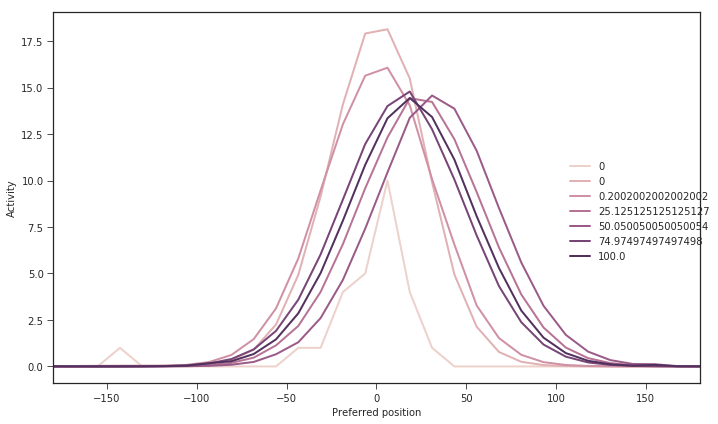

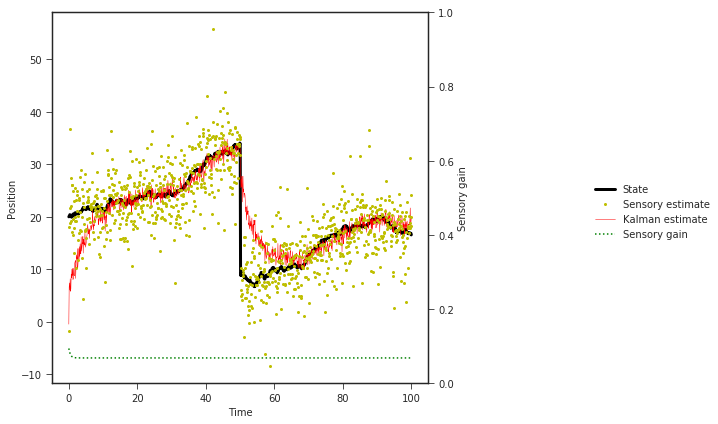

In [32]:
prefs = kalman_network.prefs

# plot of network activity over time
palette = itertools.cycle(sns.cubehelix_palette(8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
ps.append(ax1.plot(prefs, activities[1], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(2, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
#ax1.set_ylim([-40, 60])
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=0.5)
p4, = ax1.plot(ts, meas, '.', color='y', label="Sensory estimate", ms=4) 
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, ':', color='g', label="Sensory gain", ms=4)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

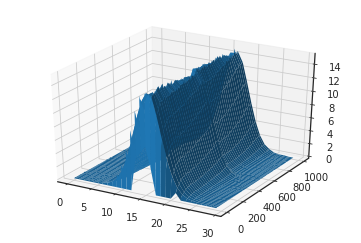

In [15]:
plot_step = 5
fig = plt.figure()
ax = fig.gca(projection='3d')
prefs_, ts_ = np.meshgrid(range(p), range(0, steps, plot_step))
act = np.array(activities)[::plot_step]
surf = ax.plot_surface(prefs_, ts_, act, linewidth=0)
plt.show()

In [29]:
## Kalman network: profiling
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

def iterate_network(ts_):
    for i, t in enumerate(ts_):
        sensory_input(state.x[0])
        kalman_network.update()
        state.update(c)
    
cProfile.run('iterate_network(ts)', 'kalnet_stats_numba')

In [30]:
ps = pstats.Stats('kalnet_stats_numba')
ps.sort_stats('tottime').print_stats(20)

Tue May  1 17:42:16 2018    kalnet_stats_numba

         799931 function calls (778627 primitive calls) in 3.590 seconds

   Ordered by: internal time
   List reduced from 144 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    1.362    0.001    1.362    0.001 /home/matthew/dev/neurkal/neurkal/neurkal.py:99(_calc_q)
    30000    0.526    0.000    0.752    0.000 /home/matthew/dev/neurkal/neurkal/neurkal.py:105(derivative)
     1000    0.347    0.000    0.347    0.000 /home/matthew/dev/neurkal/neurkal/neurkal.py:306(_set_weights)
    16000    0.172    0.000    0.172    0.000 /home/matthew/dev/neurkal/neurkal/neurkal.py:316(_calc_activity)
16000/1000    0.149    0.000    1.070    0.001 /home/matthew/dev/neurkal/neurkal/neurkal.py:189(update)
    90000    0.118    0.000    0.187    0.000 /home/matthew/dev/neurkal/neurkal/neurkal.py:38(<lambda>)
    70000    0.090    0.000    0.090    0.000 {built-in method numpy.core.multiarra

In [ ]:
# testing different input tuning functions
## Kalman network test: state estimates at each timestep
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

change = True
dx_change = 25

prior = True
x_prior = 0.0

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

states = []
inputs = []
activities = []
estimates = []
meas = []
gains = []

weird_ros = []

for i, t in enumerate(ts):
    if prior and not i:
        sensory_input(np.array([x_prior]))  # prior
        kalman_network.update(first=True)
    else:
        sensory_input(state.x[0])
        kalman_network.update()
    states.append(state.x[0])
    inputs.append(sensory_input.activity)
    # update activity in basis network implementing Kalman filter
    #print(sensory_input.cr_bound)
    activities.append(kalman_network.activity)
    estimates.append(kalman_network.estimate)
    gains.append(kalman_network.lam[0])
    meas.append(sensory_input.readout())
    if meas[-1] - state.x[0] > 40:
        weird_ros.append([state.x[0], sensory_input.activity])
    
    # update real state (+ control noise)
    if change and i == int(0.5 * steps):
        state.change(state.x - dx_change)
    state.update(c)

In [130]:
weird_ros

[]

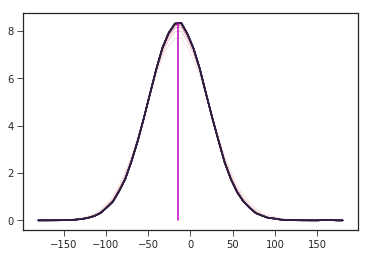

In [54]:
# test readout convergence
its = 15
ro = kalman_network.readout(iterations=its)
p_palette = itertools.cycle(sns.cubehelix_palette(its))
for i in range(its):
    plt.plot(kalman_network.prefs, kalman_network.readout_activity[i], color=next(p_palette), lw=np.sqrt(i/5))
plt.plot([ro] * 2, [0, np.max(kalman_network.readout_activity[-1])], 'm')
plt.show()

In [550]:
# Cramer-Rao bound
x = 3
sensory_input = neurkal.PopCode(200, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
prefs = sensory_input.prefs
act_f = sensory_input.act_func
sensory_input(x)
fs = [(lambda x_i: (lambda x_: act_f(x_, x_i)))(x_i)
              for x_i in prefs]
dx_f = np.array([derivative(f, x, dx=dx) for f in fs]).T
q = 1 / (dx_f @ np.linalg.inv(np.diag(sensory_input.mean_activity)) @ dx_f.T)
q

13.331207835625696

In [510]:
sensory_input.cr_bound

array([[54.13240554]])

In [ ]:
prefs = sensory_input.prefs

# plot of network activity over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn3.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
#ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(0, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, inputs[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
#fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()


In [574]:
# dynamical parameters
M = [[1, 0.5],
     [0, 0.9]]  # internal model dynamics
B = [[0],
     [1]]   # constant "motor" dynamics
Z = [[0.001, 0],
     [0, 0.001]]  # motor noise variance
c = np.array([[0],
              [1]])

In [575]:
# simulation parameters
p = 20  # units in input networks
th_r = [-180, 180]
d_th = [20, 30]
#steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 100
t_f = 100
ts = np.linspace(0, t_f, steps)

In [576]:
K_w = 3
mu = 0.001
eta = 0.005

In [577]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

In [584]:
## Kalman network test: 1D arm position
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

dx_change = [[50], [0]]

# network initialization
sensory_inputs = [neurkal.PopCode(p, space=th_r, act_func=input_act, dist=np.random.poisson),
                  neurkal.PopCode(p, space=th_r, act_func=input_act, dist=np.random.poisson)]
motor_input = neurkal.PopCode(p, space=th_r, act_func=input_act, dist=lambda x: x)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=sensory_inputs, 
                                            motor_inputs=[motor_input], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

states = []
activities = []
estimates = []
meas = []
gains = []


for i, t in enumerate(ts):
    if i:
        sensory_input(state.x[0])
        kalman_network.update()
    else:
        sensory_input(np.array([0.0]))  # prior
        kalman_network.update(first=True)
    states.append(state.x[0])
    # update activity in basis network implementing Kalman filter
    #sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    
    activities.append(kalman_network.activity)
    estimates.append(kalman_network.estimate)
    gains.append(kalman_network.lam[0])
    meas.append(sensory_input.readout())
    
    # update real state (+ control noise)
    if i == int(0.5 * steps):
        state.change(state.x - dx_change)
    state.update(c)
    
    
prefs = kalman_network.prefs

# plot of network activity over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, '.', color='g', label="Sensory gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

ValueError: setting an array element with a sequence.